# Understanding Large Language Models (LLMs)

**Learning Objectives:**
1. Understand how LLMs predict the next token
2. Learn about tokenization and how it works across different languages
3. Build intuition about vector embeddings and how meaning is represented
4. Explore vector databases and semantic search for document retrieval

---

## Python Setup

In [3]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Tokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

d:\Documents\AIMS_DSCBI_Training\AIMS-DSCBI\venv313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
# Part 1: Next Token Prediction - The Core of LLMs

## What is Next Token Prediction?

LLMs work by predicting the next token (word or subword) given a sequence of previous tokens. This simple idea is the foundation of how models like GPT, LLaMA, and others generate text.

**Key Concept:** Given "The cat sat on the", the model predicts "mat" (or "chair", "floor", etc.) based on probabilities.

Let's see this in action with GPT-2, a small open-source model.

In [ ]:
# Load GPT-2 small model (124M parameters); gpt2-medium"  # ~355M parameters
# This may take a few moments depending on your internet speed as the model is downloaded
print("Loading GPT-2 model...")
model_name = "gpt2-medium"
tokenizer = GPT2Tokenizer.from_pretrained(model_name) # load the tokenizer for GPT-2
model = GPT2LMHeadModel.from_pretrained(model_name) # load the model weights from pretrained GPT-2 
model.eval()  # Set to evaluation mode

print(f"✅ Model loaded: {model_name}")
print(f"Model size: ~124M parameters")

Loading GPT-2 model...
✅ Model loaded: gpt2-medium
Model size: ~124M parameters


## Visualizing Next Token Prediction

Let's see what the model predicts as the next token for different prompts.

In [5]:
def predict_next_tokens(text, top_k=10):
    """
    Predict the most likely next tokens given input text.
    
    Args:
        text: Input text prompt
        top_k: Number of top predictions to show
    """
    # Tokenize input
    input_ids = tokenizer.encode(text, return_tensors='pt')
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(input_ids)
        predictions = outputs.logits
    
    # Get the predictions for the next token (last position)
    next_token_logits = predictions[0, -1, :]
    
    # Convert to probabilities
    next_token_probs = torch.softmax(next_token_logits, dim=-1)
    
    # Get top k predictions
    top_probs, top_indices = torch.topk(next_token_probs, top_k)
    
    # Display results
    print(f"\n📝 Input: '{text}'\n")
    print("Top predictions for the next token:\n")
    print(f"{'Rank':<6} {'Token':<20} {'Probability':<12}")
    print("-" * 50)
    
    for rank, (prob, idx) in enumerate(zip(top_probs, top_indices), 1):
        token = tokenizer.decode([idx])
        print(f"{rank:<6} {repr(token):<20} {prob.item():.4f} ({prob.item()*100:.2f}%)")
    
    return top_probs, top_indices

In [9]:
# Example 1 Another completion
predict_next_tokens("Once upon a time")

# Example 1: Simple completion
predict_next_tokens("The capital of Rwanda is")


📝 Input: 'Once upon a time'

Top predictions for the next token:

Rank   Token                Probability 
--------------------------------------------------
1      ','                  0.6450 (64.50%)
2      ' there'             0.0552 (5.52%)
3      ' I'                 0.0341 (3.41%)
4      ' in'                0.0327 (3.27%)
5      ' the'               0.0226 (2.26%)
6      ' we'                0.0143 (1.43%)
7      ' it'                0.0110 (1.10%)
8      ' a'                 0.0088 (0.88%)
9      ' ('                 0.0081 (0.81%)
10     ' he'                0.0065 (0.65%)

📝 Input: 'The capital of Rwanda is'

Top predictions for the next token:

Rank   Token                Probability 
--------------------------------------------------
1      ' K'                 0.2803 (28.03%)
2      ' N'                 0.0652 (6.52%)
3      ' the'               0.0644 (6.44%)
4      ' G'                 0.0263 (2.63%)
5      ' now'               0.0226 (2.26%)
6      ' R'                

(tensor([0.2803, 0.0652, 0.0644, 0.0263, 0.0226, 0.0221, 0.0203, 0.0158, 0.0142,
         0.0121]),
 tensor([  509,   399,   262,   402,   783,   371,  1168, 30519,   287,   376]))

In [10]:
# Example 3: Technical context
predict_next_tokens("Machine learning is")


📝 Input: 'Machine learning is'

Top predictions for the next token:

Rank   Token                Probability 
--------------------------------------------------
1      ' a'                 0.1498 (14.98%)
2      ' the'               0.0788 (7.88%)
3      ' not'               0.0406 (4.06%)
4      ' an'                0.0403 (4.03%)
5      ' one'               0.0270 (2.70%)
6      ' often'             0.0175 (1.75%)
7      ' about'             0.0148 (1.48%)
8      ' used'              0.0144 (1.44%)
9      ' becoming'          0.0139 (1.39%)
10     ' just'              0.0138 (1.38%)


(tensor([0.1498, 0.0788, 0.0406, 0.0403, 0.0270, 0.0175, 0.0148, 0.0144, 0.0139,
         0.0138]),
 tensor([ 257,  262,  407,  281,  530, 1690,  546,  973, 5033,  655]))

### 🎯 Exercise 1: Experiment with Next Token Prediction

Try different prompts and observe:
1. How do probabilities change with different contexts?
2. What happens with ambiguous prompts?
3. Try prompts in different languages (if the model supports them)

In [11]:
# Your turn! Try your own prompts here:
your_prompt = "The weather today is"  # Change this!
predict_next_tokens(your_prompt)


📝 Input: 'The weather today is'

Top predictions for the next token:

Rank   Token                Probability 
--------------------------------------------------
1      ' very'              0.0487 (4.87%)
2      ' a'                 0.0350 (3.50%)
3      ' not'               0.0341 (3.41%)
4      ' pretty'            0.0249 (2.49%)
5      ' quite'             0.0192 (1.92%)
6      ' nice'              0.0164 (1.64%)
7      ' really'            0.0164 (1.64%)
8      ' beautiful'         0.0163 (1.63%)
9      ' perfect'           0.0162 (1.62%)
10     ' so'                0.0161 (1.61%)


(tensor([0.0487, 0.0350, 0.0341, 0.0249, 0.0192, 0.0164, 0.0164, 0.0163, 0.0162,
         0.0161]),
 tensor([ 845,  257,  407, 2495, 2407, 3621, 1107, 4950, 2818,  523]))

## Understanding Temperature in Text Generation

Temperature controls the randomness of predictions. Let's see how it affects generation.

In [12]:
def generate_with_temperature(prompt, temperature=1.0, max_length=50):
    """
    Generate text with different temperature settings.
    
    Temperature:
    - Low (0.1-0.5): More deterministic, focused
    - Medium (0.7-1.0): Balanced
    - High (1.5-2.0): More random, creative
    """
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    
    output = model.generate(
        input_ids,
        max_length=max_length,
        temperature=temperature,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    print(f"Temperature: {temperature}")
    print(f"Generated: {generated_text}\n")
    print("-" * 80)

In [13]:
# Try different temperature values to see how they affect generation
prompt = "Capital city of Rwanda"

print("=" * 80)
print(f"Prompt: '{prompt}'")
print("=" * 80)
print("\n")

# Low temperature - more deterministic and focused
generate_with_temperature(prompt, temperature=0.3)

# Medium-low temperature
generate_with_temperature(prompt, temperature=0.7)

# High temperature - more random and creative
generate_with_temperature(prompt, temperature=1.5)

# Very high temperature - very random
generate_with_temperature(prompt, temperature=2.0)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Prompt: 'Capital city of Rwanda'


Temperature: 0.3
Generated: Capital city of Rwanda, which has a population of about 2.5 million, is the poorest country in Africa.

The UN's World Food Programme said the situation was "very serious".

The UN said it was "deeply concerned

--------------------------------------------------------------------------------
Temperature: 0.7
Generated: Capital city of Rwanda has been in the throes of political upheaval since the fall of Hutu president Paul Kagame in 1994.

But Mr Kagame's successor, Mikael Tudjman, won victory over the opposition Hutu National Congress

--------------------------------------------------------------------------------
Temperature: 1.5
Generated: Capital city of Rwanda has lost more land in one time than Cairo, according to UNESCO's National Index of Environmental Indicators , but the situation there is improving.

From 2012 to 2014, Rwanda's national parks saw a 42 percent expansion – which

----------------------------------

In [14]:
generate_with_temperature("Once upon a time", temperature=1.0)

Temperature: 1.0
Generated: Once upon a time the British would have laughed with the French in the face of the 'French nation.' But one day in Paris this week, someone forgot the lesson learned."

I wonder what will happen now when President Obama gets his chance to

--------------------------------------------------------------------------------


---
# Part 2: Tokenization - Breaking Text into Pieces

## What is Tokenization?

Tokenization is the process of breaking text into smaller units (tokens) that the model can process. Different languages and writing systems require different tokenization strategies.

**Key Concepts:**
- Tokens can be words, subwords, or characters
- Different tokenizers handle different languages differently
- Languages with rich morphology (like Kinyarwanda) may be tokenized less efficiently

## Comparing Different Tokenizers

In [15]:
# Load different tokenizers
print("Loading different tokenizers...\n")

tokenizers_to_compare = {
    "GPT-2": AutoTokenizer.from_pretrained("gpt2"),
    "BERT": AutoTokenizer.from_pretrained("bert-base-uncased"),
    "RoBERTa": AutoTokenizer.from_pretrained("roberta-base"),
}

Loading different tokenizers...



In [16]:
def compare_tokenization(text, tokenizers_dict):
    """
    Compare how different tokenizers process the same text.
    """
    print(f"\n📝 Original text: '{text}'\n")
    print("=" * 80)
    
    for name, tokenizer in tokenizers_dict.items():
        tokens = tokenizer.tokenize(text)
        token_ids = tokenizer.encode(text, add_special_tokens=False)
        
        print(f"\n{name}:")
        print(f"  Number of tokens: {len(tokens)}")
        print(f"  Tokens: {tokens}")
        print(f"  Token IDs: {token_ids}")
    
    print("\n" + "=" * 80)

In [17]:
# Example 1: English text
compare_tokenization("Hello, how are you today?", tokenizers_to_compare)


📝 Original text: 'Hello, how are you today?'


GPT-2:
  Number of tokens: 7
  Tokens: ['Hello', ',', 'Ġhow', 'Ġare', 'Ġyou', 'Ġtoday', '?']
  Token IDs: [15496, 11, 703, 389, 345, 1909, 30]

BERT:
  Number of tokens: 7
  Tokens: ['hello', ',', 'how', 'are', 'you', 'today', '?']
  Token IDs: [7592, 1010, 2129, 2024, 2017, 2651, 1029]

RoBERTa:
  Number of tokens: 7
  Tokens: ['Hello', ',', 'Ġhow', 'Ġare', 'Ġyou', 'Ġtoday', '?']
  Token IDs: [31414, 6, 141, 32, 47, 452, 116]



In [18]:
# Example 2: Technical text
compare_tokenization("Machine learning is revolutionizing technology.", tokenizers_to_compare)


📝 Original text: 'Machine learning is revolutionizing technology.'


GPT-2:
  Number of tokens: 7
  Tokens: ['Machine', 'Ġlearning', 'Ġis', 'Ġrevolution', 'izing', 'Ġtechnology', '.']
  Token IDs: [37573, 4673, 318, 5854, 2890, 3037, 13]

BERT:
  Number of tokens: 7
  Tokens: ['machine', 'learning', 'is', 'revolution', '##izing', 'technology', '.']
  Token IDs: [3698, 4083, 2003, 4329, 6026, 2974, 1012]

RoBERTa:
  Number of tokens: 7
  Tokens: ['Machine', 'Ġlearning', 'Ġis', 'Ġrevolution', 'izing', 'Ġtechnology', '.']
  Token IDs: [46100, 2239, 16, 7977, 2787, 806, 4]



## Tokenization for Different Languages

Let's see how tokenization works for different languages, including Kinyarwanda. This is important because most tokenizers are trained primarily on English data.

In [19]:
def analyze_multilingual_tokenization(examples, tokenizer, tokenizer_name):
    """
    Analyze how a tokenizer handles different languages.
    """
    print(f"\n{'='*80}")
    print(f"Tokenizer: {tokenizer_name}")
    print(f"{'='*80}\n")
    
    results = {}
    
    for language, text in examples.items():
        tokens = tokenizer.tokenize(text)
        num_tokens = len(tokens)
        num_chars = len(text)
        efficiency = num_chars / num_tokens if num_tokens > 0 else 0
        
        results[language] = {
            'tokens': tokens,
            'num_tokens': num_tokens,
            'num_chars': num_chars,
            'efficiency': efficiency
        }
        
        print(f"{language}:")
        print(f"  Text: '{text}'")
        print(f"  Tokens: {tokens}")
        print(f"  Number of tokens: {num_tokens}")
        print(f"  Characters per token: {efficiency:.2f}")
        print()
    
    return results

In [20]:
# Test sentences in different languages
multilingual_examples = {
    "English": "Hello, how are you?",
    "Kinyarwanda": "Mwaramutse, mumeze mute?",
    "French": "Bonjour, comment allez-vous?",
    "Swahili": "Habari, unajisikiaje?",
    "Spanish": "Hola, ¿cómo estás?",
}


# Analyze with GPT-2 tokenizer
gpt2_results = analyze_multilingual_tokenization(
    multilingual_examples, 
    tokenizers_to_compare["GPT-2"],
    "GPT-2"
)


Tokenizer: GPT-2

English:
  Text: 'Hello, how are you?'
  Tokens: ['Hello', ',', 'Ġhow', 'Ġare', 'Ġyou', '?']
  Number of tokens: 6
  Characters per token: 3.17

Kinyarwanda:
  Text: 'Mwaramutse, mumeze mute?'
  Tokens: ['M', 'war', 'am', 'ut', 'se', ',', 'Ġm', 'ume', 'ze', 'Ġmute', '?']
  Number of tokens: 11
  Characters per token: 2.18

French:
  Text: 'Bonjour, comment allez-vous?'
  Tokens: ['Bon', 'j', 'our', ',', 'Ġcomment', 'Ġalle', 'z', '-', 'vous', '?']
  Number of tokens: 10
  Characters per token: 2.80

Swahili:
  Text: 'Habari, unajisikiaje?'
  Tokens: ['H', 'ab', 'ari', ',', 'Ġun', 'aj', 'is', 'ik', 'ia', 'je', '?']
  Number of tokens: 11
  Characters per token: 1.91

Spanish:
  Text: 'Hola, ¿cómo estás?'
  Tokens: ['H', 'ola', ',', 'ĠÂ', '¿', 'c', 'Ã³', 'mo', 'Ġest', 'Ã¡s', '?']
  Number of tokens: 11
  Characters per token: 1.64



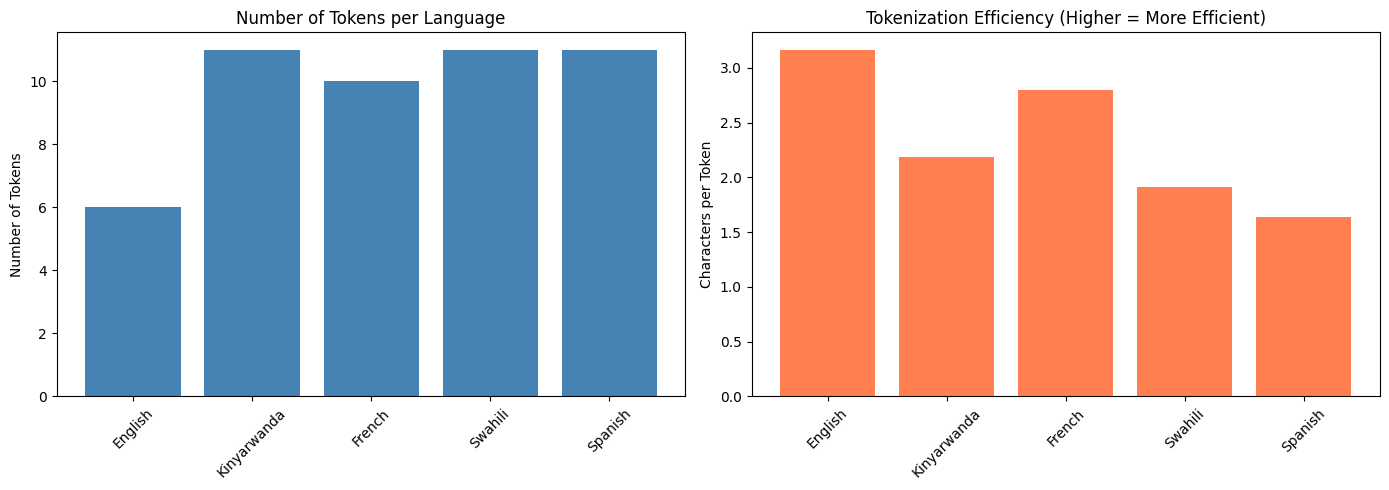

In [22]:
# Visualize tokenization efficiency across languages
def visualize_tokenization_efficiency(results):
    """
    Visualize how efficiently different languages are tokenized.
    """
    languages = list(results.keys())
    num_tokens = [results[lang]['num_tokens'] for lang in languages]
    efficiency = [results[lang]['efficiency'] for lang in languages]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Number of tokens
    ax1.bar(languages, num_tokens, color='steelblue')
    ax1.set_ylabel('Number of Tokens')
    ax1.set_title('Number of Tokens per Language')
    ax1.tick_params(axis='x', rotation=45)
    
    # Efficiency (chars per token)
    ax2.bar(languages, efficiency, color='coral')
    ax2.set_ylabel('Characters per Token')
    ax2.set_title('Tokenization Efficiency (Higher = More Efficient)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

visualize_tokenization_efficiency(gpt2_results)

## 🎯 Exercise 2: Explore Tokenization

### Part A: Experiment with Different Texts

Try tokenizing:
1. Long Kinyarwanda sentences
2. Technical terms in Kinyarwanda
3. Mixed language text (code-switching)

**Questions to consider:**
- Which languages are tokenized more efficiently?
- Why might some languages require more tokens?
- What are the implications for LLM performance?

In [23]:
# Your turn! Add your own examples
your_examples = {
    "Example 1": "Add your text here",
    "Example 2": "Add another example",
    # Add more examples
}

# Uncomment to test:
# your_results = analyze_multilingual_tokenization(your_examples, tokenizers_to_compare["GPT-2"], "GPT-2")
# visualize_tokenization_efficiency(your_results)

### Part B: OpenAI Tokenizer Playground

**Online Exercise:**

Visit the OpenAI Tokenizer Playground: https://platform.openai.com/tokenizer

**Tasks:**
1. Test the same Kinyarwanda sentences you used above
2. Compare the token counts with GPT-2
3. Try different GPT models (GPT-3.5, GPT-4) and observe differences
4. Experiment with:
   - Punctuation
   - Numbers
   - Special characters
   - Emojis

**Discussion Points:**
- Why do newer models (GPT-4) tokenize some languages more efficiently?
- What does this mean for cost and performance?
- How might this affect model training on low-resource languages?

## Understanding Subword Tokenization

Let's visualize how subword tokenization works with a detailed example.

In [24]:
def visualize_subword_tokens(text, tokenizer, tokenizer_name):
    """
    Visualize how text is broken into subword tokens.
    """
    tokens = tokenizer.tokenize(text)
    
    print(f"\nTokenizer: {tokenizer_name}")
    print(f"Original text: '{text}'")
    print(f"\nToken breakdown:")
    print("-" * 60)
    
    for i, token in enumerate(tokens, 1):
        # Show the token and its representation
        token_clean = token.replace('Ġ', '▁')  # Show spaces as ▁
        token_id = tokenizer.convert_tokens_to_ids([token])[0]
        print(f"Token {i:2d}: {token_clean:20s} (ID: {token_id})")
    
    print("-" * 60)
    print(f"Total tokens: {len(tokens)}\n")

# Example with uncommon/technical words
examples = [
    "The biotechnology industry is growing.",
    "Umunyarwanda w'umwanditsi",  # Kinyarwanda
    "Preprocessing and tokenization",
]

for example in examples:
    visualize_subword_tokens(example, tokenizers_to_compare["GPT-2"], "GPT-2")


Tokenizer: GPT-2
Original text: 'The biotechnology industry is growing.'

Token breakdown:
------------------------------------------------------------
Token  1: The                  (ID: 464)
Token  2: ▁bi                  (ID: 3182)
Token  3: otechnology          (ID: 31201)
Token  4: ▁industry            (ID: 2831)
Token  5: ▁is                  (ID: 318)
Token  6: ▁growing             (ID: 3957)
Token  7: .                    (ID: 13)
------------------------------------------------------------
Total tokens: 7


Tokenizer: GPT-2
Original text: 'Umunyarwanda w'umwanditsi'

Token breakdown:
------------------------------------------------------------
Token  1: U                    (ID: 52)
Token  2: mun                  (ID: 6199)
Token  3: y                    (ID: 88)
Token  4: ar                   (ID: 283)
Token  5: w                    (ID: 86)
Token  6: anda                 (ID: 5282)
Token  7: ▁w                   (ID: 266)
Token  8: '                    (ID: 6)
Token  9: um 

---
# Part 3: Vector Embeddings - Representing Meaning

## What are Embeddings?

Embeddings are numerical representations (vectors) of tokens that capture their meaning. Similar words have similar embeddings.

**Key Concepts:**
- Each token is represented as a vector of numbers (typically 768 or 1024 dimensions)
- Similar meanings → Similar vectors
- We can measure similarity using cosine similarity

## Extracting Embeddings from GPT-2

** embeddings (vectors of same words with same meaning) are extracted from embedding model (GPT-2) and underlying to tokenizer

In [25]:
def get_word_embedding(word, model, tokenizer):
    """
    Get the embedding vector for a word.
    """
    # Get token ID
    token_id = tokenizer.encode(word, add_special_tokens=False)[0]
    
    # Get embedding from model's embedding layer
    embedding = model.transformer.wte.weight[token_id].detach().numpy()
    
    return embedding

In [26]:
# Get embeddings for some words
words = ["king", "queen", "man", "woman", "cat", "dog", "computer", "phone"]
embeddings = {}

for word in words:
    embeddings[word] = get_word_embedding(word, model, tokenizer)
    print(f"Embedding for '{word}': shape {embeddings[word].shape}")

print(f"\nEmbedding dimension: {embeddings[words[0]].shape[0]}")

Embedding for 'king': shape (1024,)
Embedding for 'queen': shape (1024,)
Embedding for 'man': shape (1024,)
Embedding for 'woman': shape (1024,)
Embedding for 'cat': shape (1024,)
Embedding for 'dog': shape (1024,)
Embedding for 'computer': shape (1024,)
Embedding for 'phone': shape (1024,)

Embedding dimension: 1024


## Computing Similarity Between Words

In [28]:
def compute_similarity_matrix(words, embeddings):
    """
    Compute cosine similarity between all pairs of words.
    """
    n = len(words)
    similarity_matrix = np.zeros((n, n))
    
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            emb1 = embeddings[word1].reshape(1, -1)
            emb2 = embeddings[word2].reshape(1, -1)
            similarity_matrix[i, j] = cosine_similarity(emb1, emb2)[0, 0]
    
    return similarity_matrix

def visualize_similarity_matrix(words, similarity_matrix):
    """
    Visualize the similarity matrix as a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, 
                xticklabels=words, 
                yticklabels=words,
                annot=True, 
                fmt='.3f',
                cmap='coolwarm',
                center=0.5,
                vmin=0,
                vmax=1)
    plt.title('Cosine Similarity Between Word Embeddings')
    plt.tight_layout()
    plt.show()

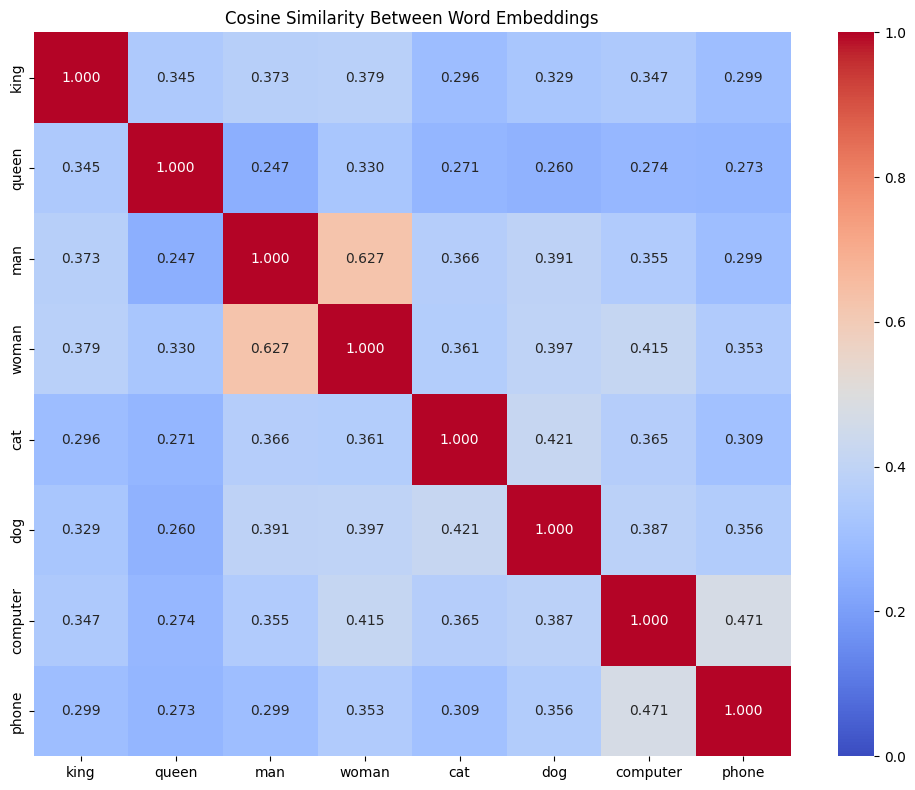

In [29]:
# Compute and visualize similarities
similarity_matrix = compute_similarity_matrix(words, embeddings)
visualize_similarity_matrix(words, similarity_matrix)

## Interpreting Similarity Scores

**What do the numbers mean?**
- 1.0: Identical (same word)
- 0.8-0.9: Very similar meaning
- 0.6-0.7: Related concepts
- 0.4-0.5: Some relation
- < 0.4: Not very related

**Observations from the heatmap:**
- Words with similar meanings have higher similarity scores
- Semantic relationships are captured (e.g., king-queen, man-woman)
- Category relationships (e.g., cat-dog, computer-phone)

In [30]:
def find_most_similar(target_word, words, embeddings, top_k=5):
    """
    Find the most similar words to a target word.
    """
    target_emb = embeddings[target_word].reshape(1, -1)
    similarities = []
    
    for word in words:
        if word != target_word:
            emb = embeddings[word].reshape(1, -1)
            sim = cosine_similarity(target_emb, emb)[0, 0]
            similarities.append((word, sim))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nWords most similar to '{target_word}':")
    print("-" * 40)
    for i, (word, sim) in enumerate(similarities[:top_k], 1):
        print(f"{i}. {word:<15} (similarity: {sim:.4f})")

find_most_similar("king", words, embeddings)
find_most_similar("computer", words, embeddings)


Words most similar to 'king':
----------------------------------------
1. woman           (similarity: 0.3785)
2. man             (similarity: 0.3726)
3. computer        (similarity: 0.3469)
4. queen           (similarity: 0.3451)
5. dog             (similarity: 0.3288)

Words most similar to 'computer':
----------------------------------------
1. phone           (similarity: 0.4714)
2. woman           (similarity: 0.4145)
3. dog             (similarity: 0.3865)
4. cat             (similarity: 0.3651)
5. man             (similarity: 0.3548)


## Visualizing Embeddings in 2D

Embeddings exist in high-dimensional space (768 dimensions for GPT-2). We can use dimensionality reduction to visualize them in 2D.

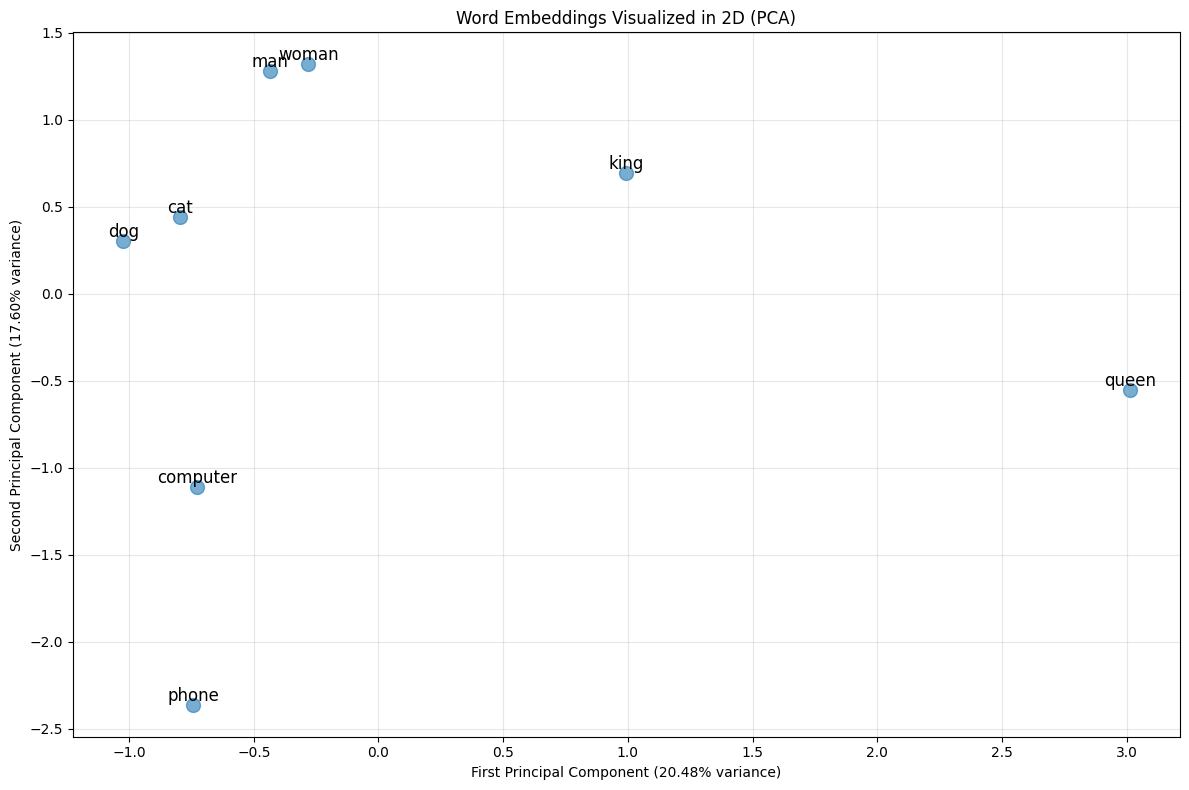


Total variance explained: 38.08%


In [31]:
def visualize_embeddings_2d(words, embeddings):
    """
    Visualize embeddings in 2D using PCA.
    """
    # Prepare embedding matrix
    embedding_matrix = np.array([embeddings[word] for word in words])
    
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embedding_matrix)
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100, alpha=0.6)
    
    # Add labels
    for i, word in enumerate(words):
        plt.annotate(word, 
                    (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=12,
                    ha='center',
                    va='bottom')
    
    plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('Word Embeddings Visualized in 2D (PCA)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal variance explained: {sum(pca.explained_variance_ratio_):.2%}")

visualize_embeddings_2d(words, embeddings)

## Exercise 3: Explore Embeddings with Kinyarwanda Words

### Instructions:

1. **Create a themed word list** with 8-12 Kinyarwanda words (choose ONE theme):
   - Foods and drinks
   - Colors
   - Animals
   - Greetings/emotions
   - Or any theme of your choice!

2. **Include English translations** for comparison (mix them in the same list)

3. **Plot the embeddings** using the provided plotting function

4. **Observe and discuss:**
   - Do Kinyarwanda and English words cluster separately?
   - Are semantically related words closer together?
   - Are translation pairs near each other?
   - What surprises do you see?


**Tip:** 
- If a word isn't found in the tokenizer, try variations or common spellings. GPT-2 may not have extensive Kinyarwanda vocabulary.
- Later you can explore on HuggingFace LLMs which support Kinyarwanda. For example, you can try this model: ```"Davlan/afro-xlmr-base"```

In [32]:
def get_word_embedding(word, model, tokenizer):
    token_id = tokenizer.encode(word, add_special_tokens=False)[0]
    
    # For GPT-2 style models
    if hasattr(model, 'transformer'):
        embedding = model.transformer.wte.weight[token_id]
    # For BERT style models
    else:
        embedding = model.embeddings.word_embeddings.weight[token_id]
    
    return embedding.detach().numpy()

In [34]:
from transformers import AutoTokenizer, AutoModel

model_name = "Davlan/afro-xlmr-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# 2. Test embeddings
word = "muraho"
embedding = get_word_embedding(word, model, tokenizer)
print(f"Embedding for '{word}': {embedding[:5]}...")  # First 5 values


Some weights of XLMRobertaModel were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding for 'muraho': [ 0.12481459  0.13901062 -0.15466802  0.20673008  0.1730843 ]...



Similarity Analysis:


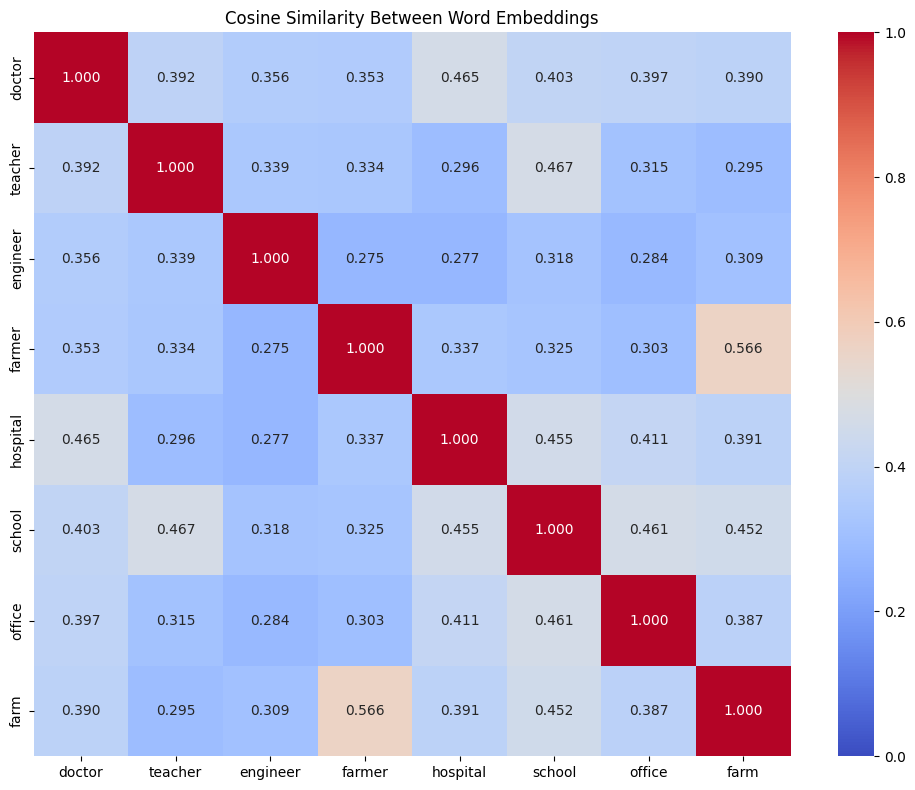

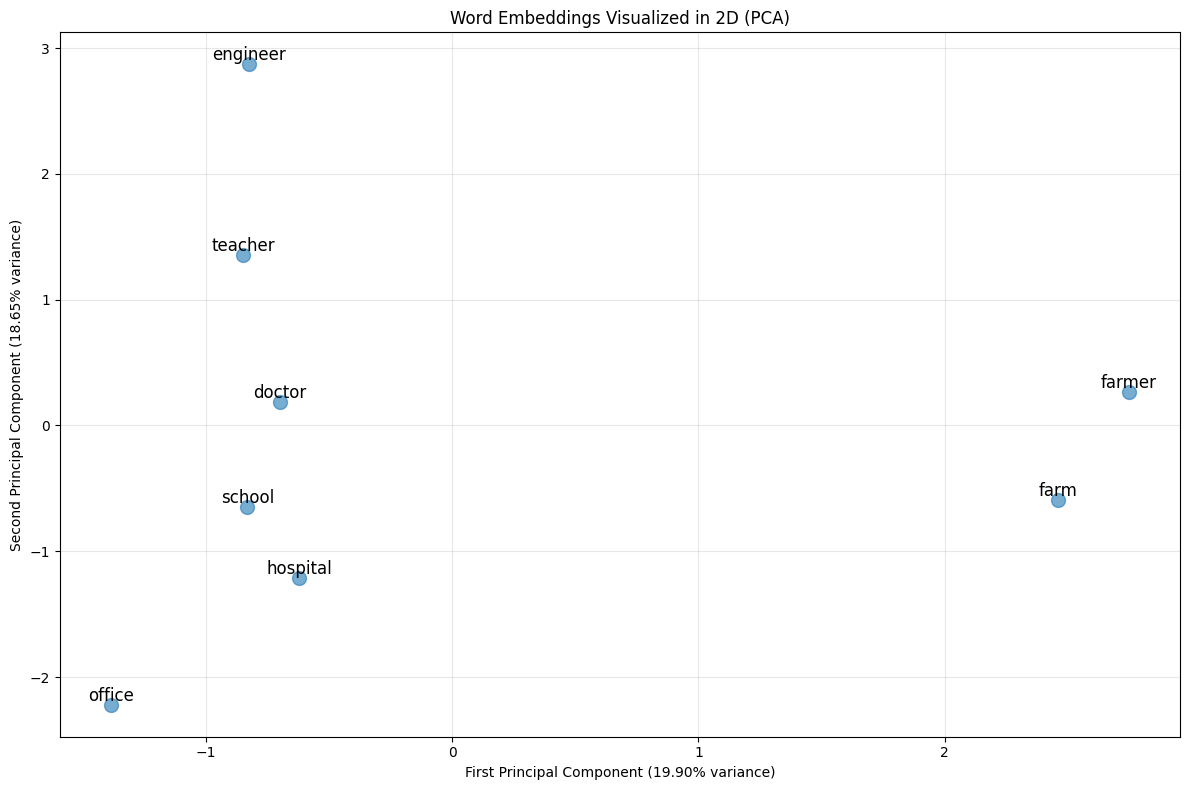


Total variance explained: 38.55%


In [35]:
# Your turn! Create your own word list
your_words = [
    "doctor", "teacher", "engineer", "farmer",
    "hospital", "school", "office", "farm"
]

# Get embeddings
your_embeddings = {}
for word in your_words:
    try:
        your_embeddings[word] = get_word_embedding(word, model, tokenizer)
    except:
        print(f"Skipping: {word}")

# Analyze
if len(your_embeddings) > 1:
    print("\nSimilarity Analysis:")
    valid_words = list(your_embeddings.keys())
    sim_matrix = compute_similarity_matrix(valid_words, your_embeddings)
    visualize_similarity_matrix(valid_words, sim_matrix)
    visualize_embeddings_2d(valid_words, your_embeddings)

---
# Part 4: Vector Databases - Storing and Retrieving Documents

## What are Vector Databases?

Vector databases are specialized databases designed to store and efficiently search through vector embeddings. They are crucial for:
- **Semantic search**: Finding documents by meaning, not just keywords
- **RAG (Retrieval Augmented Generation)**: Providing LLMs with relevant context
- **Recommendation systems**: Finding similar items
- **Question answering**: Retrieving relevant information

**How it works:**
1. Convert documents into embeddings
2. Store embeddings in a vector database
3. Convert user queries into embeddings
4. Find similar documents using vector similarity search

## Installing Vector Database Libraries

We'll use **ChromaDB** - a lightweight, open-source vector database perfect for learning.

In [33]:
!pip install chromadb sentence-transformers --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
# Install ChromaDB and sentence-transformers for better embeddings

import chromadb
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
from typing import List
import uuid

## Creating a Sample Document Collection

Let's create a collection of documents about Rwanda for our vector database. In real-world applications, these documents would typically come from files (like PDFs) or databases.

In [46]:
# Sample documents about Rwanda and technology
documents = [
    {
        "text": "Rwanda is a landlocked country in East Africa, known as the land of a thousand hills. The capital city is Kigali.",
        "metadata": {"category": "geography", "topic": "rwanda_overview"}
    },
    {
        "text": "Kigali is one of the cleanest cities in Africa. It has modern infrastructure and is a growing technology hub.",
        "metadata": {"category": "cities", "topic": "kigali"}
    },
    {
        "text": "Rwanda has made significant progress in technology adoption. The country has invested heavily in ICT infrastructure and digital literacy.",
        "metadata": {"category": "technology", "topic": "digital_transformation"}
    },
    {
        "text": "Machine learning and artificial intelligence are emerging fields in Rwanda. Several startups are working on AI solutions for agriculture and healthcare.",
        "metadata": {"category": "technology", "topic": "ai_ml"}
    },
    {
        "text": "Kinyarwanda is the national language of Rwanda, spoken by most of the population. French and English are also official languages.",
        "metadata": {"category": "language", "topic": "kinyarwanda"}
    },
    {
        "text": "The African Institute for Mathematical Sciences (AIMS) in Rwanda provides advanced training in mathematical sciences and data science.",
        "metadata": {"category": "education", "topic": "aims"}
    },
    {
        "text": "Rwanda's economy has grown rapidly, with technology and services sectors leading the growth. The country aims to become a knowledge-based economy.",
        "metadata": {"category": "economy", "topic": "growth"}
    },
    {
        "text": "Natural language processing for Kinyarwanda is an active research area. Challenges include limited training data and unique linguistic features.",
        "metadata": {"category": "technology", "topic": "nlp_kinyarwanda"}
    },
    {
        "text": "Mountain gorillas can be found in the Volcanoes National Park in Rwanda. Gorilla trekking is a major tourist attraction.",
        "metadata": {"category": "tourism", "topic": "wildlife"}
    },
    {
        "text": "Rwanda has implemented various digital government services. Citizens can access many government services online through the Irembo platform.",
        "metadata": {"category": "technology", "topic": "e_government"}
    }
]

## Setting Up the Embedding Model

Note that embedding models are different from generative LLMs. While LLMs like GPT-2 generate text, embedding models are specialized for converting text into numerical vectors. We'll use a Sentence Transformer model that's optimized for creating semantic embeddings of text.

In [47]:
# Load a sentence transformer model
# Using 'all-MiniLM-L6-v2' - a good balance of quality and speed
print("Loading embedding model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

print(f"Model loaded: all-MiniLM-L6-v2")
print(f"Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

# Test the model
test_text = "Rwanda is a beautiful country"
test_embedding = embedding_model.encode(test_text)
print(f"\nTest embedding shape: {test_embedding.shape}")

Loading embedding model...
Model loaded: all-MiniLM-L6-v2
Embedding dimension: 384

Test embedding shape: (384,)


## Creating a Vector Database

Now let's create a ChromaDB database and add our documents to it.

In [48]:
# Initialize ChromaDB client
chroma_client = chromadb.Client(Settings(
    anonymized_telemetry=False,
    allow_reset=True
))

# Create or get a collection
collection_name = "rwanda_documents"
collection = chroma_client.create_collection(
    name=collection_name,
    metadata={"description": "Collection of documents about Rwanda"}
)

InternalError: Collection [rwanda_documents] already exists

## Adding Documents to the Vector Database

Let's convert our documents to embeddings and store them in ChromaDB.

In [49]:
def add_documents_to_collection(documents, collection, embedding_model):
    """
    Convert documents to embeddings and add them to the collection.
    """
    print("Converting documents to embeddings...\n")
    
    for i, doc in enumerate(documents, 1):
        # Create embedding
        embedding = embedding_model.encode(doc["text"]).tolist()
        
        # Generate unique ID
        doc_id = f"doc_{i}"
        
        # Add to collection
        collection.add(
            embeddings=[embedding],
            documents=[doc["text"]],
            metadatas=[doc["metadata"]],
            ids=[doc_id]
        )
        
        print(f"✓ Added document {i}/{len(documents)}: {doc['text'][:60]}...")
    
    print(f"\n✅ Successfully added {len(documents)} documents to the vector database!")

# Add all documents to the collection
add_documents_to_collection(documents, collection, embedding_model)

# Verify the count
print(f"\nTotal documents in collection: {collection.count()}")

Converting documents to embeddings...

✓ Added document 1/10: Rwanda is a landlocked country in East Africa, known as the ...
✓ Added document 2/10: Kigali is one of the cleanest cities in Africa. It has moder...
✓ Added document 3/10: Rwanda has made significant progress in technology adoption....
✓ Added document 4/10: Machine learning and artificial intelligence are emerging fi...
✓ Added document 5/10: Kinyarwanda is the national language of Rwanda, spoken by mo...
✓ Added document 6/10: The African Institute for Mathematical Sciences (AIMS) in Rw...
✓ Added document 7/10: Rwanda's economy has grown rapidly, with technology and serv...
✓ Added document 8/10: Natural language processing for Kinyarwanda is an active res...
✓ Added document 9/10: Mountain gorillas can be found in the Volcanoes National Par...
✓ Added document 10/10: Rwanda has implemented various digital government services. ...

✅ Successfully added 10 documents to the vector database!

Total documents in collection:

## Semantic Search: Querying the Vector Database

Now comes the exciting part - searching for relevant documents based on the meaning of our query!

In [50]:
def semantic_search(query, collection, embedding_model, n_results=3):
    """
    Perform semantic search on the vector database.
    
    Args:
        query: Text query to search for
        collection: ChromaDB collection
        embedding_model: Model to create query embedding
        n_results: Number of results to return
    """
    # Convert query to embedding
    query_embedding = embedding_model.encode(query).tolist()
    
    # Search the collection
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )
    
    # Display results
    print(f"\n🔍 Query: '{query}'\n")
    print("="*80)
    print(f"\nTop {n_results} most relevant documents:\n")
    
    for i, (doc, metadata, distance) in enumerate(zip(
        results['documents'][0],
        results['metadatas'][0],
        results['distances'][0]
    ), 1):
        similarity = 1 - distance  # Convert distance to similarity
        print(f"Result {i}:")
        print(f"  Similarity: {similarity:.4f} ({similarity*100:.2f}%)")
        print(f"  Category: {metadata['category']}")
        print(f"  Text: {doc}")
        print()
    
    return results

In [51]:
# Example queries
queries = [
    "Tell me about artificial intelligence in Rwanda",
    "What is the capital city?",
    "Information about Kinyarwanda language",
]

for query in queries:
    semantic_search(query, collection, embedding_model)
    print("-"*80)


🔍 Query: 'Tell me about artificial intelligence in Rwanda'


Top 3 most relevant documents:

Result 1:
  Similarity: 0.4899 (48.99%)
  Category: technology
  Text: Machine learning and artificial intelligence are emerging fields in Rwanda. Several startups are working on AI solutions for agriculture and healthcare.

Result 2:
  Similarity: 0.1248 (12.48%)
  Category: technology
  Text: Rwanda has made significant progress in technology adoption. The country has invested heavily in ICT infrastructure and digital literacy.

Result 3:
  Similarity: 0.1229 (12.29%)
  Category: education
  Text: The African Institute for Mathematical Sciences (AIMS) in Rwanda provides advanced training in mathematical sciences and data science.

--------------------------------------------------------------------------------

🔍 Query: 'What is the capital city?'


Top 3 most relevant documents:

Result 1:
  Similarity: -0.3900 (-39.00%)
  Category: geography
  Text: Rwanda is a landlocked country in East A

## Understanding the Results

**Key Observations:**

1. **Semantic Matching**: The search finds relevant documents even when they don't contain the exact query words
2. **Similarity Scores**: Higher scores (closer to 1.0) indicate more relevant documents
3. **Context Awareness**: The system understands that "artificial intelligence" relates to "machine learning" and "technology"

**Compare this to keyword search:**
- Keyword search: Looks for exact word matches
- Semantic search: Understands meaning and context

## Visualizing Query Results

Let's visualize how queries relate to documents in the embedding space.

In [52]:
# Simple keyword search function
# Example documents
# Example queries
queries = [
    "artificial intelligence Rwanda",
    "capital city",
    "Kinyarwanda language"
]

def keyword_search(query, docs):
    """
    Returns documents that contain any of the words in the query.
    """
    query_words = query.lower().split()
    results = [doc for doc in docs if any(word in doc.lower() for word in query_words)]
    return results

# Run keyword search
for query in queries:
    print(f"Query: {query}\n")
    results = keyword_search(query, documents)
    
    if results:
        for i, res in enumerate(results, 1):
            print(f"{i}. {res}")
    else:
        print("No results found.")
    
    print("-" * 80)


Query: artificial intelligence Rwanda



AttributeError: 'dict' object has no attribute 'lower'

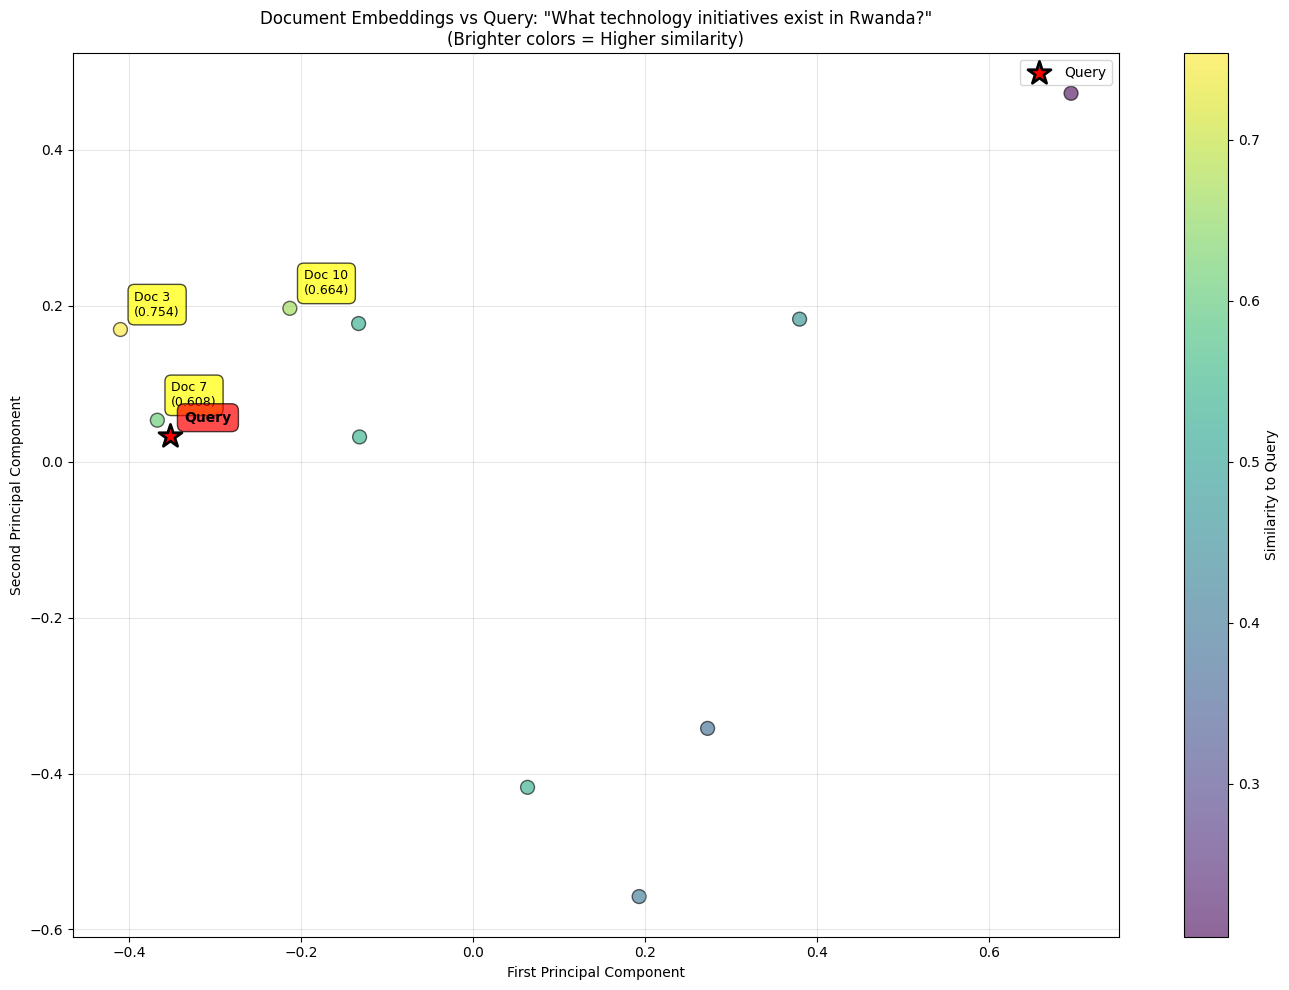

In [53]:
def visualize_query_results(query, documents, embedding_model, n_results=5):
    """
    Visualize query and document embeddings in 2D space.
    """
    # Get embeddings for all documents and query
    doc_texts = [doc['text'] for doc in documents]
    doc_embeddings = embedding_model.encode(doc_texts)
    query_embedding = embedding_model.encode(query)
    
    # Combine all embeddings
    all_embeddings = np.vstack([doc_embeddings, query_embedding.reshape(1, -1)])
    
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(all_embeddings)
    
    # Split back into docs and query
    doc_embeddings_2d = embeddings_2d[:-1]
    query_embedding_2d = embeddings_2d[-1]
    
    # Calculate similarities
    similarities = cosine_similarity([query_embedding], doc_embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][:n_results]
    
    # Plot
    plt.figure(figsize=(14, 10))
    
    # Plot documents
    colors = plt.cm.viridis(similarities)
    scatter = plt.scatter(doc_embeddings_2d[:, 0], doc_embeddings_2d[:, 1], 
                         c=similarities, cmap='viridis', s=100, alpha=0.6, 
                         edgecolors='black', linewidth=1)
    
    # Plot query
    plt.scatter(query_embedding_2d[0], query_embedding_2d[1], 
               c='red', s=300, marker='*', edgecolors='black', 
               linewidth=2, label='Query', zorder=5)
    
    # Add labels for top results
    for idx in top_indices:
        plt.annotate(f"Doc {idx+1}\n({similarities[idx]:.3f})",
                    (doc_embeddings_2d[idx, 0], doc_embeddings_2d[idx, 1]),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                    fontsize=9, ha='left')
    
    # Add query label
    plt.annotate('Query',
                (query_embedding_2d[0], query_embedding_2d[1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.7),
                fontsize=10, fontweight='bold', ha='left')
    
    plt.colorbar(scatter, label='Similarity to Query')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(f'Document Embeddings vs Query: "{query}"\n(Brighter colors = Higher similarity)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize a query
visualize_query_results(
    "What technology initiatives exist in Rwanda?", 
    documents, 
    embedding_model,
    n_results=3
)

## Filtering with Metadata

Vector databases allow you to combine semantic search with metadata filtering.

In [54]:
def search_with_filter(query, collection, embedding_model, filter_dict, n_results=3):
    """
    Perform semantic search with metadata filtering.
    """
    query_embedding = embedding_model.encode(query).tolist()
    
    # Search with filter
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results,
        where=filter_dict
    )
    
    print(f"\n🔍 Query: '{query}'")
    print(f"📋 Filter: {filter_dict}\n")
    print("="*80)
    
    if not results['documents'][0]:
        print("No documents found matching the filter.")
        return
    
    print(f"\nTop {len(results['documents'][0])} results:\n")
    
    for i, (doc, metadata, distance) in enumerate(zip(
        results['documents'][0],
        results['metadatas'][0],
        results['distances'][0]
    ), 1):
        similarity = 1 - distance
        print(f"Result {i}:")
        print(f"  Similarity: {similarity:.4f}")
        print(f"  Category: {metadata['category']}")
        print(f"  Topic: {metadata['topic']}")
        print(f"  Text: {doc}")
        print()

# Example: Search only in technology category
search_with_filter(
    "machine learning and AI",
    collection,
    embedding_model,
    filter_dict={"category": "technology"},
    n_results=3
)

print("-"*80)

# Example: Search only in geography category
search_with_filter(
    "beautiful landscapes",
    collection,
    embedding_model,
    filter_dict={"category": "geography"},
    n_results=2
)


🔍 Query: 'machine learning and AI'
📋 Filter: {'category': 'technology'}


Top 3 results:

Result 1:
  Similarity: 0.1307
  Category: technology
  Topic: ai_ml
  Text: Machine learning and artificial intelligence are emerging fields in Rwanda. Several startups are working on AI solutions for agriculture and healthcare.

Result 2:
  Similarity: -0.5285
  Category: technology
  Topic: nlp_kinyarwanda
  Text: Natural language processing for Kinyarwanda is an active research area. Challenges include limited training data and unique linguistic features.

Result 3:
  Similarity: -0.7902
  Category: technology
  Topic: digital_transformation
  Text: Rwanda has made significant progress in technology adoption. The country has invested heavily in ICT infrastructure and digital literacy.

--------------------------------------------------------------------------------

🔍 Query: 'beautiful landscapes'
📋 Filter: {'category': 'geography'}


Top 1 results:

Result 1:
  Similarity: -0.6929
  Category

## Exercise 4: Build Your Own Vector Database

### Part A: Create Your Own Document Collection

**Task:** Create a collection of documents about a topic of your choice:
1. Pick a topic (e.g., Rwandan history, technology startups, agriculture, education)
2. Create 8-10 documents about this topic
3. Add relevant metadata to each document
4. Store them in a vector database

**Bonus:** Include some documents in Kinyarwanda if the embedding model supports it!

### Part B: Experiment with Different Queries

**Tasks:**
1. Try synonymous queries (e.g., "AI" vs "artificial intelligence")
2. Try queries in different languages
3. Experiment with metadata filtering

**Questions to consider:**
- How does semantic search handle synonyms?
- What happens with very short vs very long queries?
- How does the number of documents affect search quality?
- How could you improve retrieval accuracy?

In [55]:
# Experiment space
# Try different queries and observe the results

my_query = "Your experimental query here"
# semantic_search(my_query, collection, embedding_model)

# Summary

## Core Concepts
### 1. Tokenization
- Text is split into tokens (words, subwords, characters)
- Low-resource languages like Kinyarwanda use more tokens → higher costs and longer contexts
- Solution: Use multilingual models or train language-specific tokenizers

### 2. Vector Embeddings
- Words as vectors in high-dimensional space
- Similar meanings = similar vectors
- Measured using cosine similarity

### 3. Vector Databases
- Store and search embeddings efficiently
- Enable semantic search by meaning, not keywords
- Power RAG (Retrieval Augmented Generation) systems

## Popular Vector Databases
- **ChromaDB**: Lightweight, prototyping
- **Pinecone**: Managed cloud
- **Weaviate**: Open-source
- **Milvus/FAISS**: High-performance


## Next Steps
- Explore multilingual models (AfroXLMR, XLM-RoBERTa)
- Build custom tokenizers for Kinyarwanda
- Fine-tune models for local languages
- Contribute to low-resource language datasets

## Resources
- OpenAI Tokenizer: https://platform.openai.com/tokenizer
- Hugging Face: https://huggingface.co/transformers/
